In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
import numpy as np
import gymnasium as gym
import orbax.checkpoint

import numpy as np
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
import collections
import flax
from icrl.maze.utility import (
    RLTrainState,
    VectorCritic,
    ValueCritic,
    concatenated_indices,
    BatchData,
)
from icrl.maze.exp.OpiDice import OpiDice


env_id = "Maze2d_simple"
env = gym.make(env_id)

key = jax.random.PRNGKey(0)
key, actor_key, qf_key, ent_vkey = jax.random.split(key, 4)

obs = jnp.array([env.observation_space.sample()])
action = jnp.array([env.action_space.sample()])


/home/guorui/miniconda3/envs/sepsis/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/home/guorui/miniconda3/envs/sepsis/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  PRNGKey = Union[jax.random.KeyArray, jax.Array]
/home/guorui/miniconda3/envs/sepsis/lib/python3.10/site-packages/flax/linen/module.py:77: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  KeyArray = Union[jax.Array, jax.random.KeyArray]  # pyl

In [3]:
def get_index_dict():
    checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    data = checkpointer.restore(
        "/home/guorui/jax-rl/tmp/buffer/Maze2d_simple/Maze2d_simple__new_sac_reward_shaping__1__1700637466/"
    )
    dataset = {}
    start_index = 0
    end_index = 50000
    dataset["observations"] = jnp.array(
        data[0][start_index:end_index, 0, :4].astype(jnp.float32)
    )
    startpoint = (-1, -1)
    dataset["index"] = jnp.array(
        (dataset["observations"][:, 0] == startpoint[0])
        & (dataset["observations"][:, 1] == startpoint[1])
    )
    dataset["index"],intervals = concatenated_indices(dataset["index"])
    num_parts = 20
    xy_values = np.linspace(-1, 1, num_parts)
    v_values = np.linspace(-0.5, 1, num_parts)

    # Create an empty dictionary
    index_dict = {}

    # Iterate through each element and update the dictionary
    ids=[]
    for index in range(len(intervals)):
        interval=intervals[index]
        if (jnp.array(data[3][interval[0]:interval[1], 0])).any():
            ids.append(index)
        element=dataset["observations"][interval[0]:interval[1]]
        x_index = np.digitize(element[:,0], xy_values)
        y_index = np.digitize(element[:,1], xy_values)
        vx_index = np.digitize(element[:,3], v_values)
        vy_index = np.digitize(element[:,4], v_values)
        # Convert the indices to a tuple to use it as a key
        for key in set(zip(x_index, y_index, vx_index, vy_index)):
            if key in index_dict:
                index_dict[key].add(index)
            else:
                index_dict[key] = set([index])

    # Print the resulting dictionary
    good_keys=list(filter(lambda x:(np.array(x)>2).all() and (np.array(x)<18).all(),list(index_dict.keys())))
    new_index_dict={key:index_dict[key] for key in good_keys if len(index_dict[key])>1 and len(index_dict[key].intersection(ids))>0}
    new_index_dict={k: v for k, v in sorted(new_index_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    return new_index_dict,intervals
index_dict,intervals=get_index_dict()
print(intervals)
print(index_dict)

{(10, 3, 16, 16): {5, 167, 7, 178, 124, 191}, (9, 3, 16, 16): {5, 170, 44, 178, 124, 189}, (3, 3, 14, 14): {164, 104, 172, 179, 23, 186}, (12, 4, 17, 17): {193, 5, 167, 174, 183}, (5, 3, 16, 16): {164, 8, 119, 186, 190}, (3, 3, 15, 15): {164, 172, 110, 179, 23}, (14, 5, 16, 16): {184, 193, 5, 174}, (13, 5, 14, 14): {191, 5, 182, 183}, (15, 6, 13, 13): {187, 44, 5, 182}, (15, 6, 11, 11): {187, 44, 5, 182}, (3, 3, 13, 13): {186, 179, 164, 23}, (15, 6, 8, 8): {44, 5, 182}, (16, 12, 15, 15): {192, 185, 5}, (16, 6, 16, 16): {182, 5, 174}, (10, 3, 9, 9): {193, 5, 167}, (16, 6, 12, 12): {160, 44, 5}, (16, 7, 16, 16): {187, 5, 182}, (16, 7, 17, 17): {187, 5, 182}, (15, 6, 10, 10): {44, 5, 182}, (16, 7, 14, 14): {187, 5, 182}, (15, 5, 14, 14): {5, 174, 189}, (10, 3, 15, 15): {124, 5, 191}, (13, 5, 17, 17): {187, 5, 183}, (14, 5, 17, 17): {184, 193, 5}, (12, 4, 16, 16): {193, 5, 183}, (16, 7, 13, 13): {187, 5, 182}, (16, 7, 15, 15): {187, 5, 182}, (9, 3, 14, 14): {124, 5, 189}, (5, 3, 14, 14): {

In [7]:
np.array([y-x for x,y in intervals]).argmin()

63

In [9]:
def get_random_data(index_list):
    checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    data = checkpointer.restore(
        "/home/guorui/jax-rl/tmp/buffer/Maze2d_simple/Maze2d_simple__new_sac_reward_shaping__1__1700637466/"
    )
    dataset = {}
    start_index = 0
    end_index = 50000
    dataset["observations"] = jnp.array(
        data[0][start_index:end_index, 0, :4].astype(jnp.float32)
    )
    startpoint = (-1, -1)
    dataset["index"] = jnp.array(
        (dataset["observations"][:, 0] == startpoint[0])
        & (dataset["observations"][:, 1] == startpoint[1])
    )

    import random
    intervals=concatenated_indices(dataset["index"])[1]
    sample_interval = [intervals[i] for i in index_list]
    print(index_list)
    selected_index = np.concatenate(
        [np.arange(start, end) for (start, end) in sample_interval]
    )
    dataset["observations"] = jnp.array(
        data[0][selected_index, 0, :4].astype(jnp.float32)
    )
    dataset["next_observations"] = jnp.array(
        data[1][selected_index, 0, :4].astype(jnp.float32)
    )
    dataset["actions"] = jnp.array(data[2][selected_index, 0])
    dataset["rewards"] = (jnp.array(data[4][selected_index, 0].clip(0)) - 100) / 100
    dataset["infos"] = data[5]
    dataset["terminals"] = jnp.array(data[3][selected_index, 0])
    dataset["timeouts"] = jnp.zeros_like(dataset["terminals"])
    startpoint = (-1, -1)
    dataset["index"] = jnp.array(
        (dataset["observations"][:, 0] == startpoint[0])
        & (dataset["observations"][:, 1] == startpoint[1])
    )
    dataset["index"] = jnp.array(concatenated_indices(dataset["index"])[0])
    dataset["init_eff"] = 1 / (dataset["index"] == 0).mean()
    dataset["init_obs"] = dataset["observations"][dataset["index"] == 0]
    return dataset

{(10, 3, 16, 16): {5, 7, 124, 167, 178, 191},
 (9, 3, 16, 16): {5, 44, 124, 170, 178, 189},
 (3, 3, 14, 14): {23, 104, 164, 172, 179, 186},
 (12, 4, 17, 17): {5, 167, 174, 183, 193},
 (5, 3, 16, 16): {8, 119, 164, 186, 190},
 (3, 3, 15, 15): {23, 110, 164, 172, 179},
 (14, 5, 16, 16): {5, 174, 184, 193},
 (13, 5, 14, 14): {5, 182, 183, 191},
 (15, 6, 13, 13): {5, 44, 182, 187},
 (15, 6, 11, 11): {5, 44, 182, 187},
 (3, 3, 13, 13): {23, 164, 179, 186},
 (15, 6, 8, 8): {5, 44, 182},
 (16, 12, 15, 15): {5, 185, 192},
 (16, 6, 16, 16): {5, 174, 182},
 (10, 3, 9, 9): {5, 167, 193},
 (16, 6, 12, 12): {5, 44, 160},
 (16, 7, 16, 16): {5, 182, 187},
 (16, 7, 17, 17): {5, 182, 187},
 (15, 6, 10, 10): {5, 44, 182},
 (16, 7, 14, 14): {5, 182, 187},
 (15, 5, 14, 14): {5, 174, 189},
 (10, 3, 15, 15): {5, 124, 191},
 (13, 5, 17, 17): {5, 183, 187},
 (14, 5, 17, 17): {5, 184, 193},
 (12, 4, 16, 16): {5, 183, 193},
 (16, 7, 13, 13): {5, 182, 187},
 (16, 7, 15, 15): {5, 182, 187},
 (9, 3, 14, 14): {5, 1

In [ ]:
import itertools
for key in list(itertools.islice(index_dict, 3,20)):
    dataset = get_random_data(index_dict[key])
    plt.figure()
    indices = np.where(dataset["index"] == 0)[0]
    last_indices = np.concatenate([indices[1:], [len(dataset["index"])]])

    for r,l in zip(indices,last_indices):
        plt.plot(
        dataset["observations"][r:l, 0],
        dataset["observations"][r:l, 1],
        # color=dataset["terminals"]
        )


[193, 5, 8, 63]


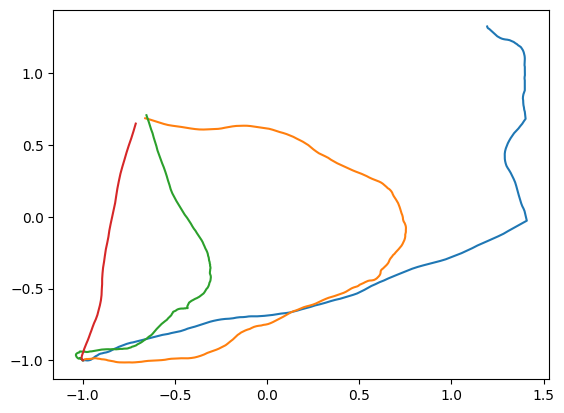

In [10]:
dataset = get_random_data([193, 5,   8,63 ])
plt.figure()
indices = np.where(dataset["index"] == 0)[0]
last_indices = np.concatenate([indices[1:], [len(dataset["index"])]])

for r,l in zip(indices,last_indices):
    plt.plot(
    dataset["observations"][r:l, 0],
    dataset["observations"][r:l, 1],
    # color=dataset["terminals"]
    )
